<a href="https://www.kaggle.com/msafi04/frauddetection-in-bank-transactions-aucpr?scriptVersionId=82565725" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
#pd.set_option('display.max_rows', None)

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, auc

from sklearn.preprocessing import StandardScaler, LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from plotly import tools
from plotly.offline import iplot
import plotly.graph_objs as go
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

from IPython.display import display

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['axes.titlesize'] = 16
plt.style.use('seaborn-whitegrid')
sns.set_palette('Set2')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from time import time, strftime, gmtime
start = time()
import datetime
print(str(datetime.datetime.now()))

import warnings
warnings.simplefilter('ignore')

/kaggle/input/banksim1/bs140513_032310.csv
/kaggle/input/banksim1/bsNET140513_032310.csv
2021-12-17 05:45:15.825402


In [2]:
bank_trans = pd.read_csv('/kaggle/input/banksim1/bs140513_032310.csv')
print(bank_trans.shape)
bank_trans.head()

(594643, 10)


,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [3]:
bank_network = pd.read_csv('/kaggle/input/banksim1/bsNET140513_032310.csv')
print(bank_network.shape)
bank_network.head()

(594643, 5)


,Source,Target,Weight,typeTrans,fraud
0,'C1093826151','M348934600',4.55,'es_transportation',0
1,'C352968107','M348934600',39.68,'es_transportation',0
2,'C2054744914','M1823072687',26.89,'es_transportation',0
3,'C1760612790','M348934600',17.25,'es_transportation',0
4,'C757503768','M348934600',35.72,'es_transportation',0


In [4]:
bank_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


__Check for Missing values__

In [5]:
bank_trans.isna().any()

step           False
customer       False
age            False
gender         False
zipcodeOri     False
merchant       False
zipMerchant    False
category       False
amount         False
fraud          False
dtype: bool

# Data Cleaning
Before proceeding its better to remove the quotes from the strings in the columns

In [6]:
cols_to_change = [c for c in bank_trans.columns if c not in ['step', 'amount', 'fraud']]
cols_to_change

['customer',
 'age',
 'gender',
 'zipcodeOri',
 'merchant',
 'zipMerchant',
 'category']

In [7]:
bank_trans[cols_to_change] = bank_trans[cols_to_change].applymap(lambda x: x.replace("'", ""))

# EDA

In [8]:
for col in bank_trans.columns:
    print(f"Feature {col.upper()} has {bank_trans[col].nunique()} items")

Feature STEP has 180 items
Feature CUSTOMER has 4112 items
Feature AGE has 8 items
Feature GENDER has 4 items
Feature ZIPCODEORI has 1 items
Feature MERCHANT has 50 items
Feature ZIPMERCHANT has 1 items
Feature CATEGORY has 15 items
Feature AMOUNT has 23767 items
Feature FRAUD has 2 items


The 'zipcodeOri' and 'zipMerchant' has only one unique item in them, we can drop these two features from the dataset

In [9]:
bank_trans = bank_trans.drop(['zipcodeOri', 'zipMerchant'], axis = 1)
bank_trans.head(2)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0


In [10]:
#Viz Utils

def countplot_helper(data: pd.DataFrame, col: str, title: str = None, hue: str = None):
    plt.figure(figsize = (16, 12))
    plt.title(title)
    ax = sns.countplot(data = data, x = col, order = data[col].value_counts().index,
                       hue = hue if hue else None)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(data[col]), 2)}%",
                ha = 'center')
    if data[col].nunique() > 5:
        plt.xticks(rotation = 45)
    plt.show()

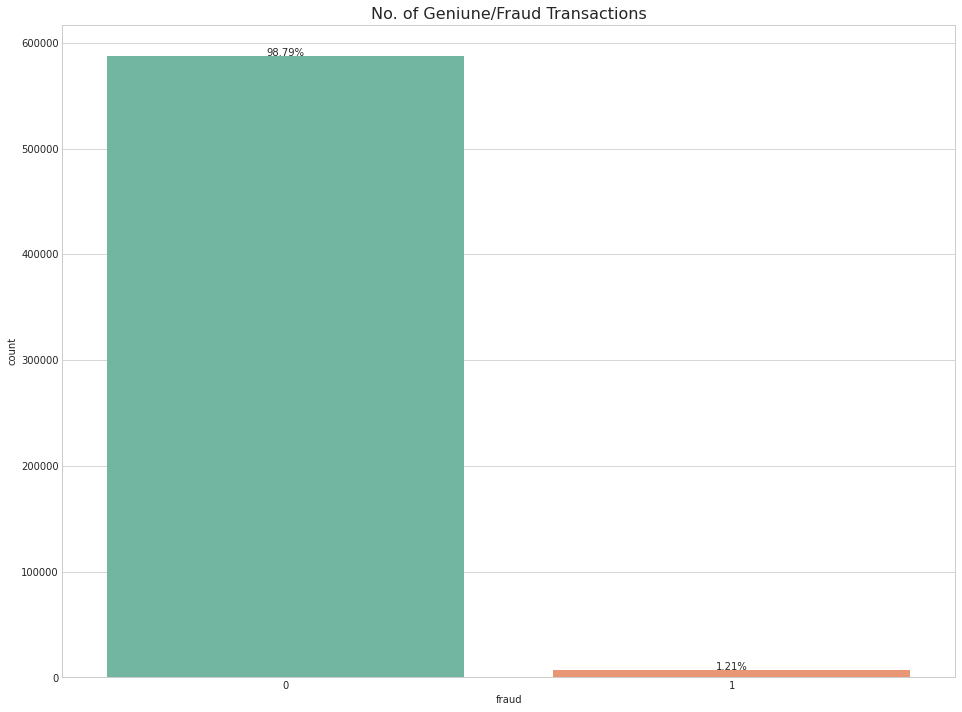

In [11]:
countplot_helper(bank_trans, 'fraud', title = 'No. of Geniune/Fraud Transactions')

- There % of Fraudulent transactions in the dataset is 1.21% of the total transactions
- Heavily imbalanced dataset

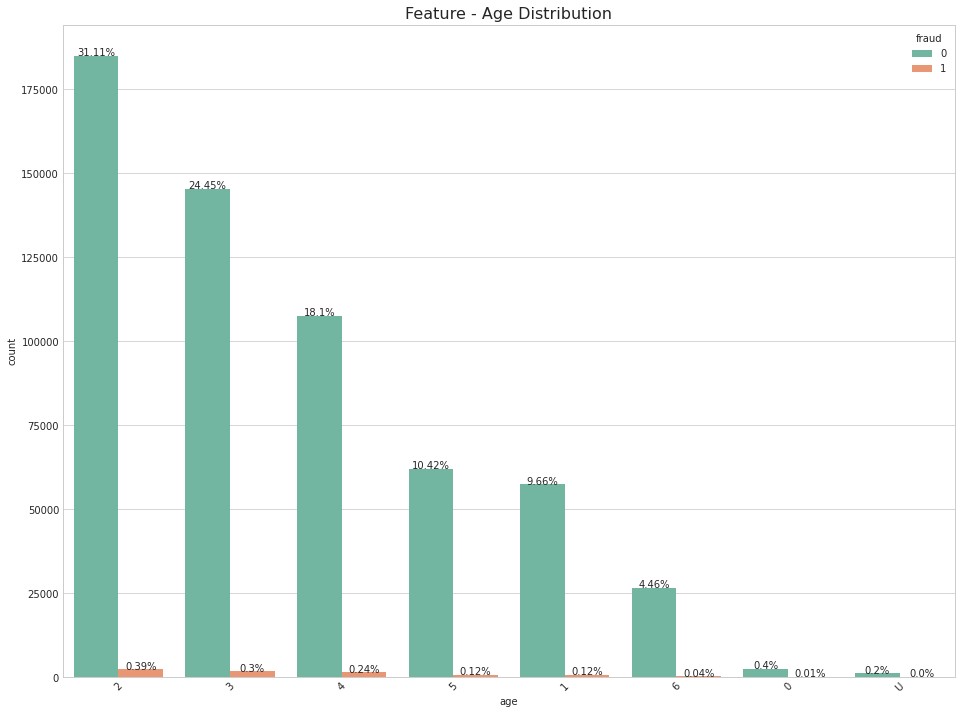

In [12]:
countplot_helper(bank_trans, 'age', title = 'Feature - Age Distribution', hue = 'fraud')

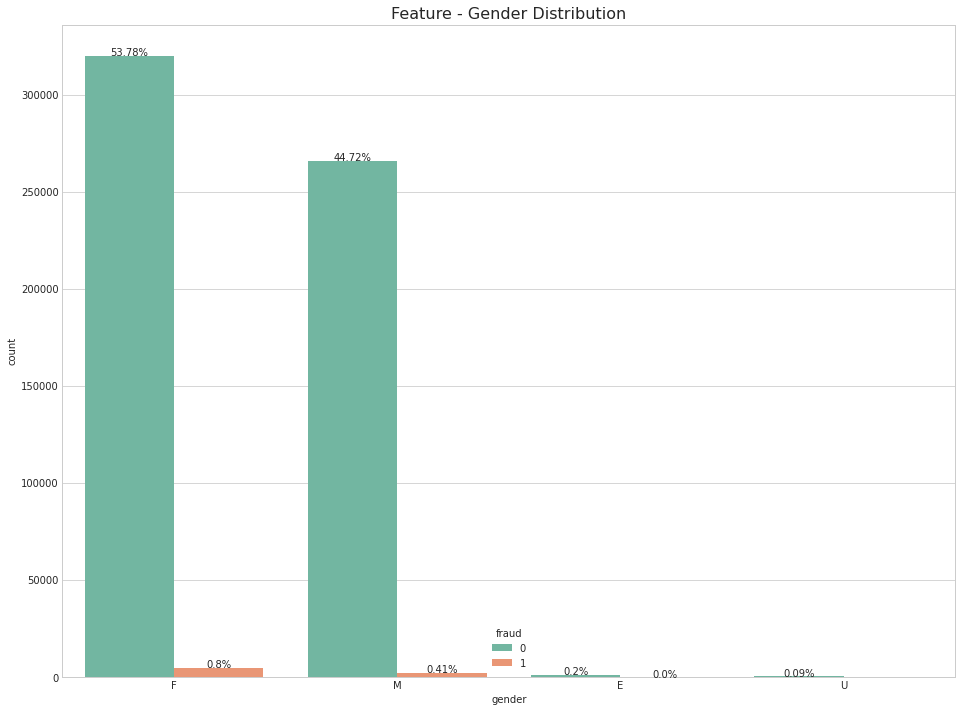

In [13]:
countplot_helper(bank_trans, 'gender', title = 'Feature - Gender Distribution', hue = 'fraud')

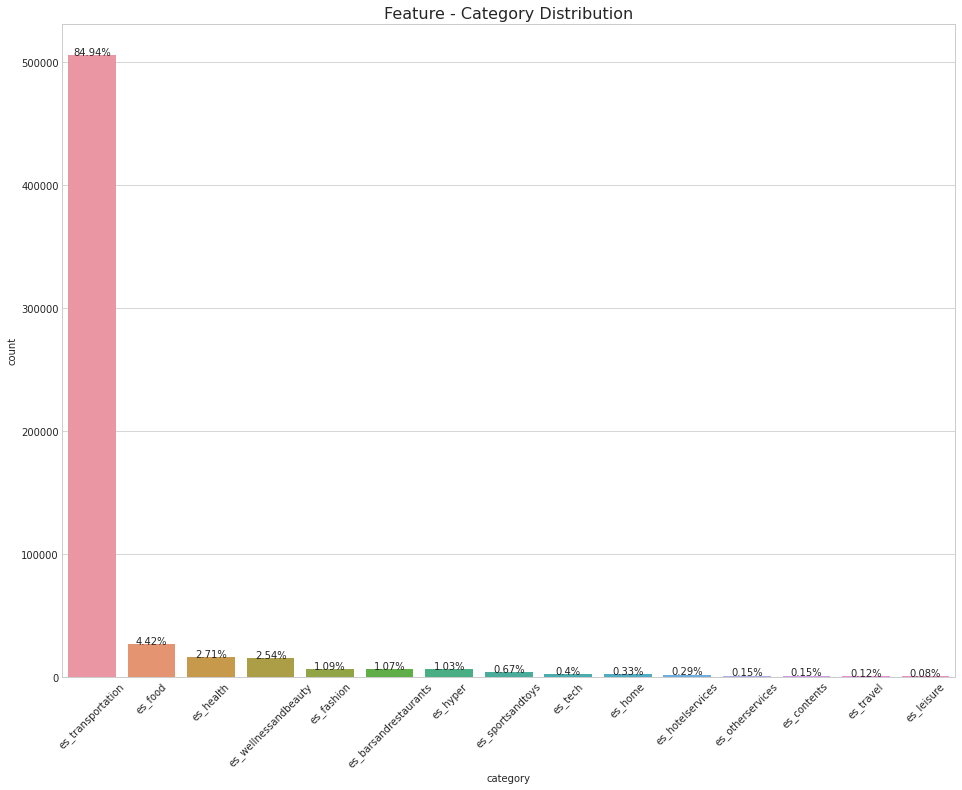

In [14]:
countplot_helper(bank_trans, 'category', title = 'Feature - Category Distribution')

- Most of the transactions has happened in 'es_transportation' category
- It would be interesting to find out in which category the fradulent transactions happens

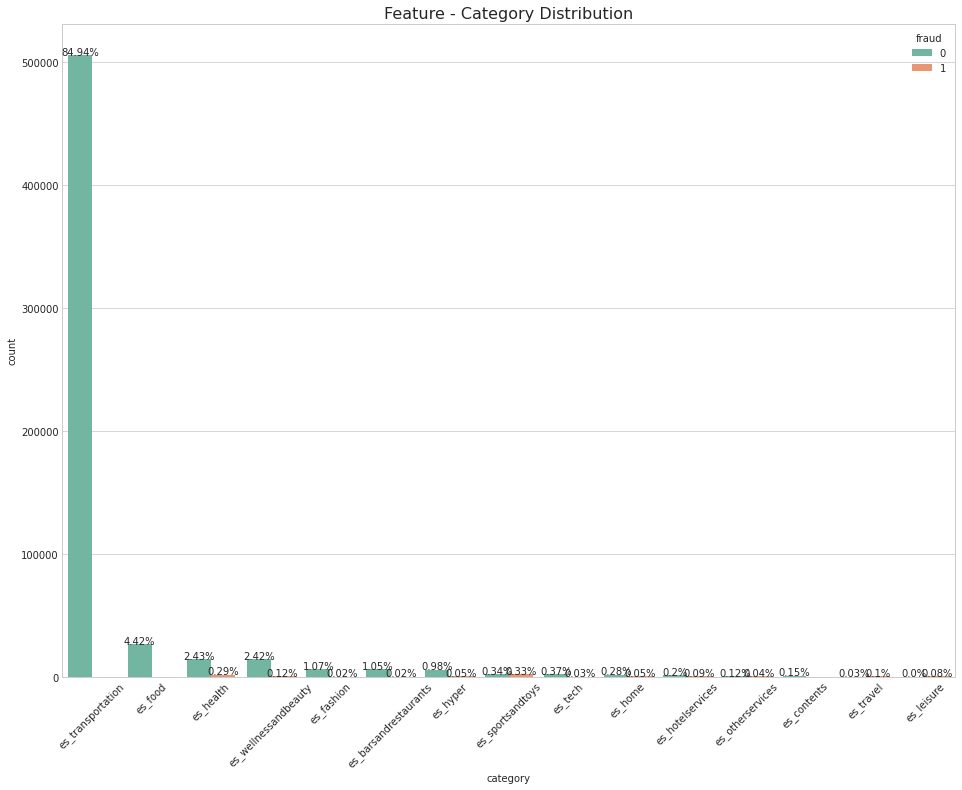

In [15]:
countplot_helper(bank_trans, 'category', title = 'Feature - Category Distribution', hue = 'fraud')

- There is no Fraud transaction in 'es_transportation'
- Let's remove the es_transportation category and check the distribution

In [16]:
fraud_cats = list(bank_trans[bank_trans['fraud'] == 1]['category'].unique())
print("The categories where fraud has been detected:")
print(*fraud_cats, sep = '\n')

The categories where fraud has been detected:
es_health
es_hotelservices
es_wellnessandbeauty
es_sportsandtoys
es_home
es_otherservices
es_fashion
es_leisure
es_travel
es_barsandrestaurants
es_tech
es_hyper


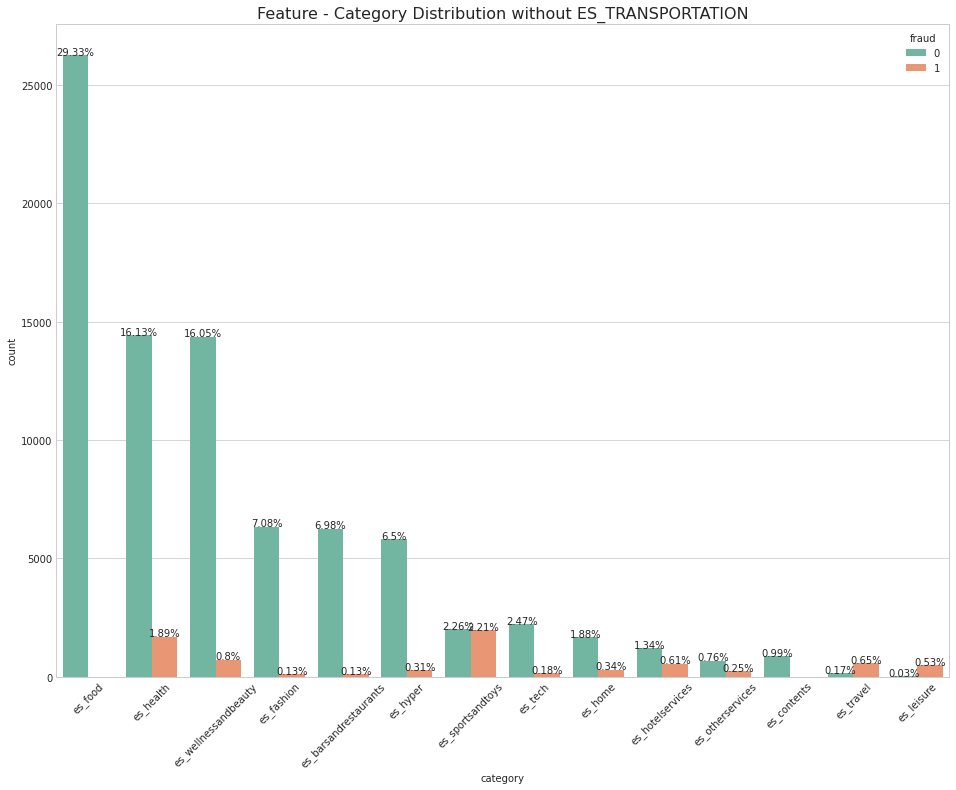

In [17]:
temp = bank_trans[bank_trans['category'] != 'es_transportation']
countplot_helper(temp, 'category', title = 'Feature - Category Distribution without ES_TRANSPORTATION', hue = 'fraud')

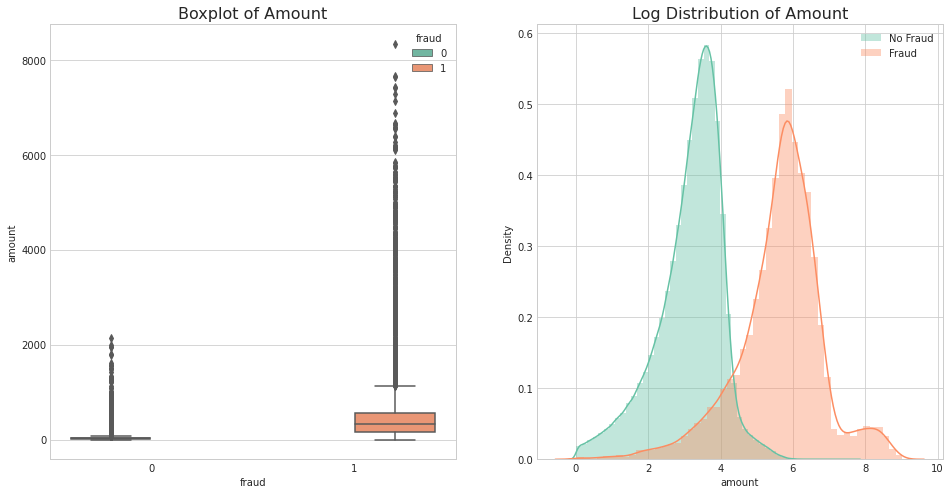

In [18]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (16, 8))
ax1.set_title('Boxplot of Amount')
sns.boxplot(data = bank_trans, x = 'fraud', y = 'amount', hue = 'fraud', ax = ax1)

ax2.set_title('Log Distribution of Amount')
sns.distplot(np.log1p(bank_trans[bank_trans['fraud'] == 0]['amount']), label = 'No Fraud', ax = ax2)
sns.distplot(np.log1p(bank_trans[bank_trans['fraud'] == 1]['amount']), label = 'Fraud', ax = ax2)
ax2.legend()
plt.show()

In [19]:
print('Fraud Transaction:')
print(f"Max. Transaction Amount: {bank_trans[bank_trans['fraud'] == 1]['amount'].max()}")
print(f"Min. Transaction Amount: {bank_trans[bank_trans['fraud'] == 1]['amount'].min()}")
print(f"Avg. Transaction Amount: {bank_trans[bank_trans['fraud'] == 1]['amount'].mean()}")
print(f"Median Transaction Amount: {bank_trans[bank_trans['fraud'] == 1]['amount'].median()}")
print('\nNo Fraud Transaction:')
print(f"Max. Transaction Amount: {bank_trans[bank_trans['fraud'] == 0]['amount'].max()}")
print(f"Min. Transaction Amount: {bank_trans[bank_trans['fraud'] == 0]['amount'].min()}")
print(f"Avg. Transaction Amount: {bank_trans[bank_trans['fraud'] == 0]['amount'].mean()}")
print(f"Median Transaction Amount: {bank_trans[bank_trans['fraud'] == 9]['amount'].median()}")

Fraud Transaction:
Max. Transaction Amount: 8329.96
Min. Transaction Amount: 0.03
Avg. Transaction Amount: 530.9265513888895
Median Transaction Amount: 319.175

No Fraud Transaction:
Max. Transaction Amount: 2144.86
Min. Transaction Amount: 0.0
Avg. Transaction Amount: 31.84723038660696
Median Transaction Amount: nan


- The average amount of transaction is higher in Fraud compared to No Fraud

In [20]:
def bivariate_plots(df, x, y):
    fig, ax = plt.subplots()
    plt.scatter(df[x], df[y], c = 'blue', edgecolors = 'none', alpha = 0.5)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{x} vs. {y}')
    plt.show()

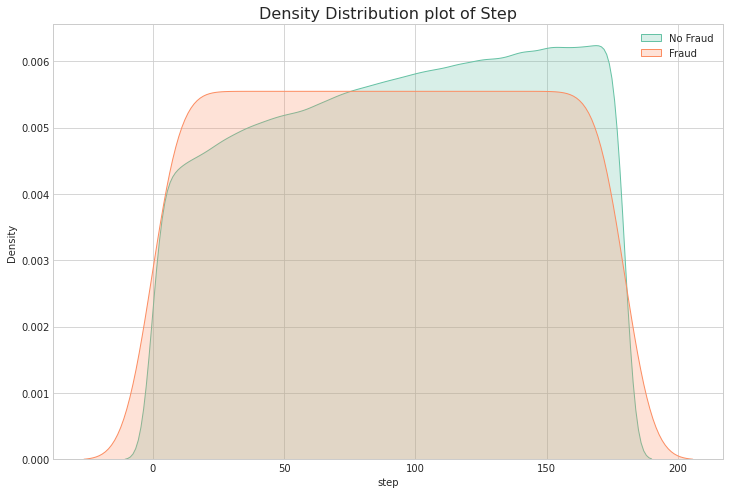

In [21]:
plt.title('Density Distribution plot of Step')
sns.kdeplot(bank_trans[bank_trans['fraud'] == 0]['step'], shade = True, label = 'No Fraud')
sns.kdeplot(bank_trans[bank_trans['fraud'] == 1]['step'], shade = True, label = 'Fraud')
plt.legend()
plt.show()

In [22]:
fraud_df = bank_trans[bank_trans['fraud'] == 1].copy()
nofraud_df = bank_trans[bank_trans['fraud'] == 0].copy()
fraud_df.shape, nofraud_df.shape

((7200, 8), (587443, 8))

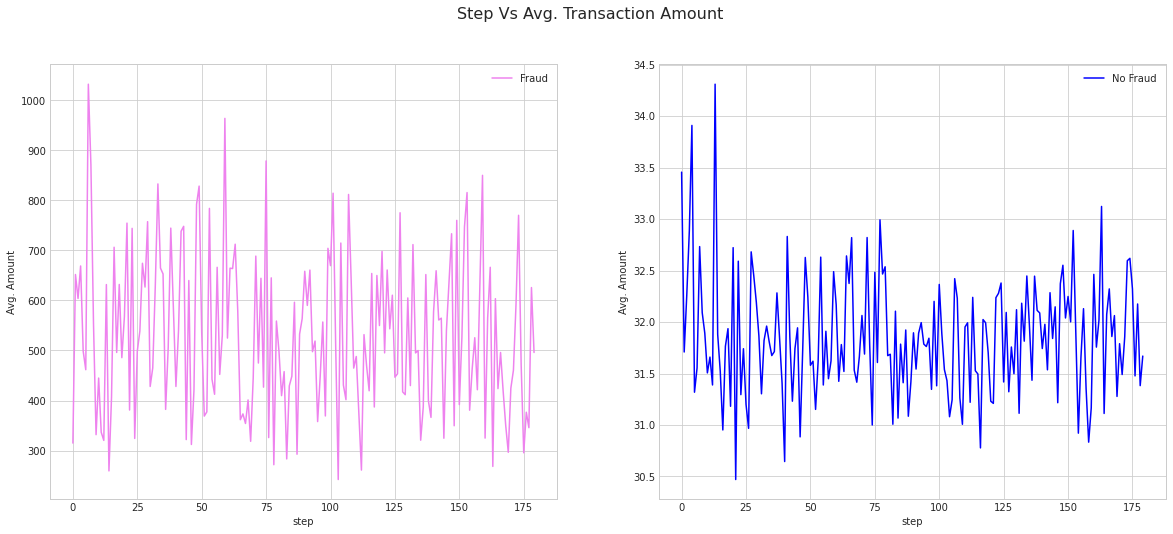

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (20, 8))
fraud_df.groupby('step')['amount'].mean().plot(kind = 'line', label = 'Fraud', color = 'violet', legend = True, ax = ax1)
ax1.set_ylabel('Avg. Amount')
nofraud_df.groupby('step')['amount'].mean().plot(kind = 'line', label = 'No Fraud', color = 'blue', legend = True, ax = ax2)
ax2.set_ylabel('Avg. Amount')
plt.suptitle('Step Vs Avg. Transaction Amount', fontsize = 16)
plt.show()

- The average amount spent during every 'step' is higher for fradulent transactions than normal ones
- Lets check how gender and age influences the transactions

In [24]:
def subplots_helper(df: pd.DataFrame, col: str):
    colors = plt.rcParams['axes.prop_cycle']()
    for i, gender in enumerate(df[col].unique()):
        fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 8))
        c = next(colors)['color']
        fraud_df[fraud_df[col] == gender].groupby('step')['amount'].mean().plot(kind = 'line', label = 'Fraud', color = c, legend = True, ax = ax1)
        ax1.set_ylabel('Avg. Amount')
        c = next(colors)['color']
        nofraud_df[nofraud_df[col] == gender].groupby('step')['amount'].mean().plot(kind = 'line', label = 'No Fraud', color = c, legend = True, ax = ax2)
        ax2.set_ylabel('Avg. Amount')
        plt.suptitle(f'Step Vs Avg. Transaction Amount for {col}: {gender}', y = 0.95, fontsize = 16)
        plt.figtext(0.5, 0.01, f"Figure {i + 1}", ha = 'center', fontsize = 16, bbox = {"facecolor": "grey", "alpha": 0.5, "pad": 5})
        plt.show()
    return None

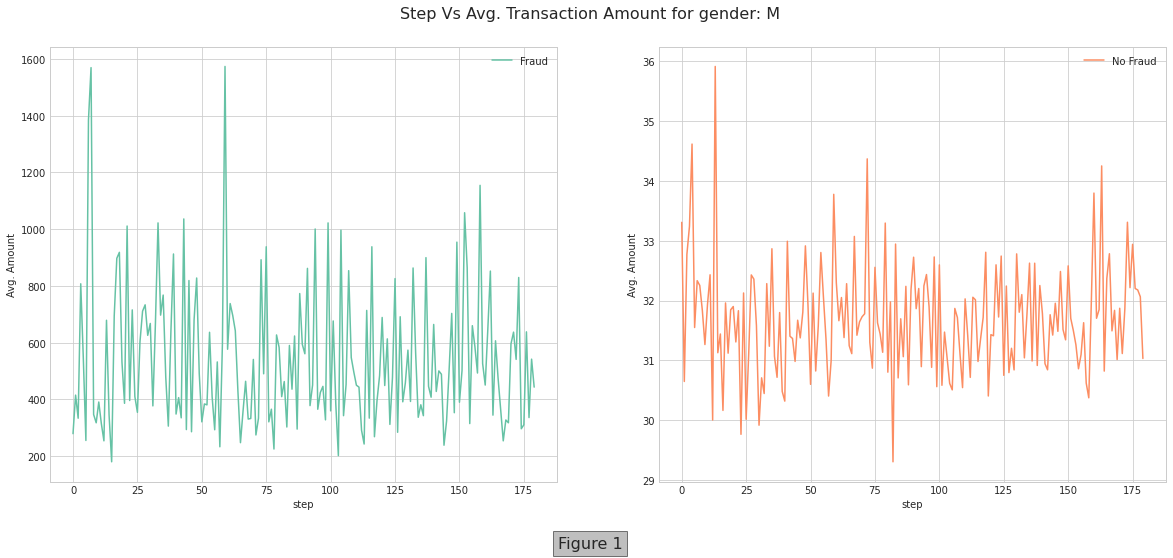

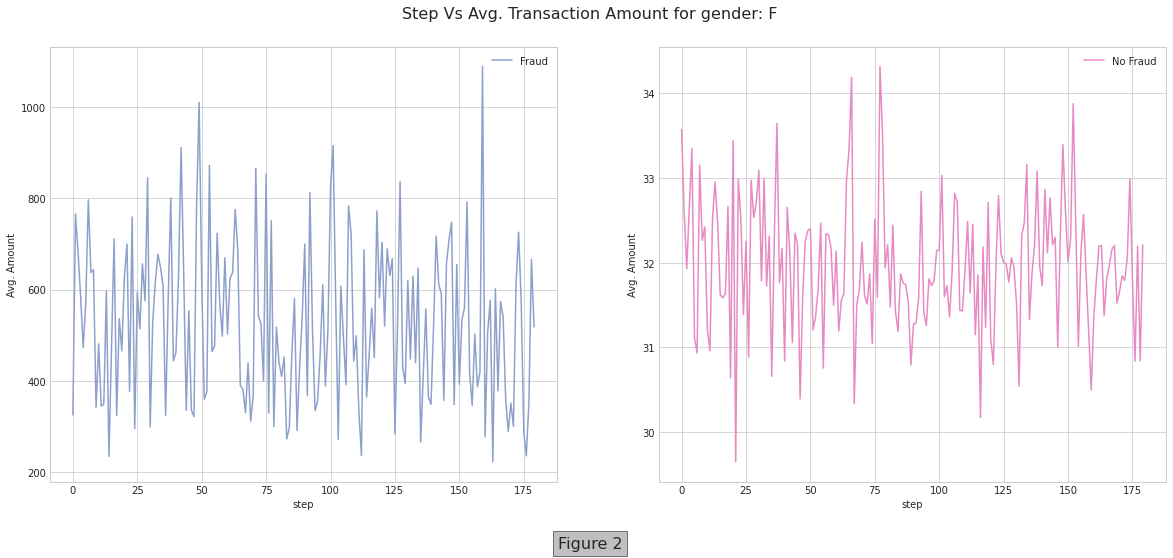

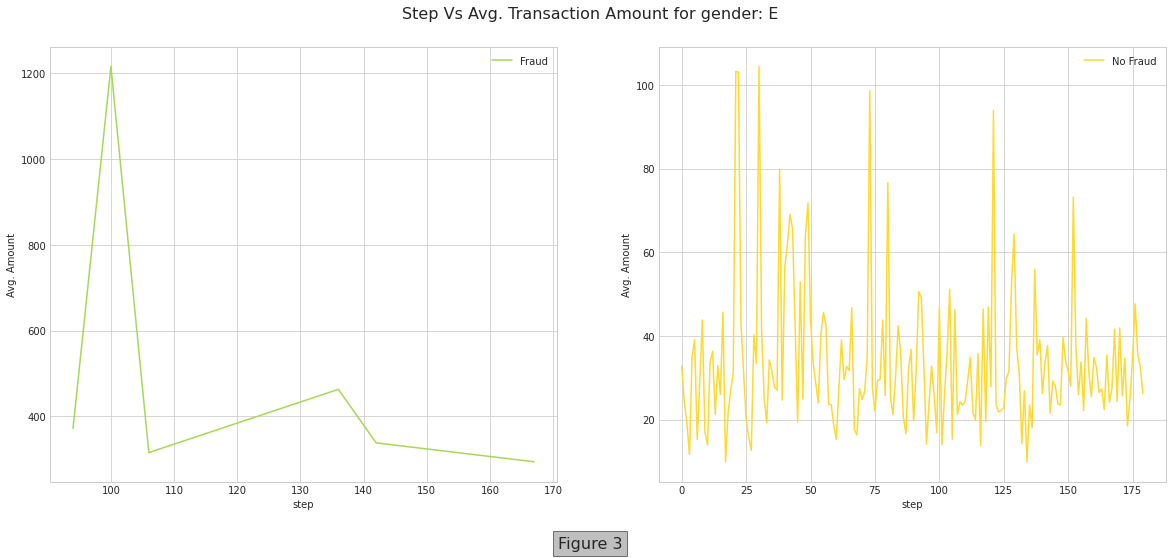

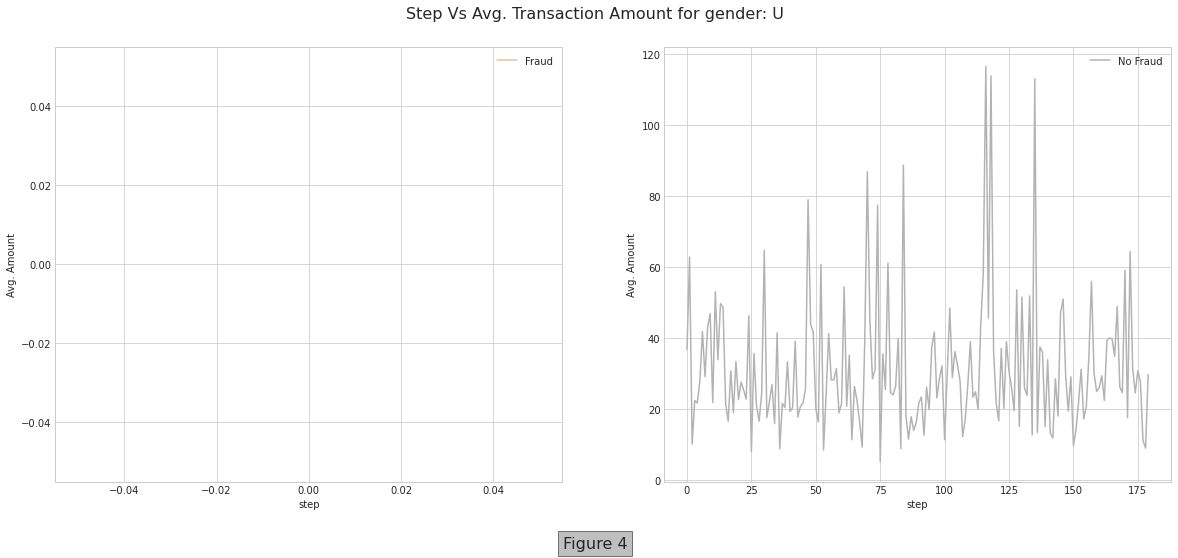

In [25]:
subplots_helper(bank_trans, 'gender')

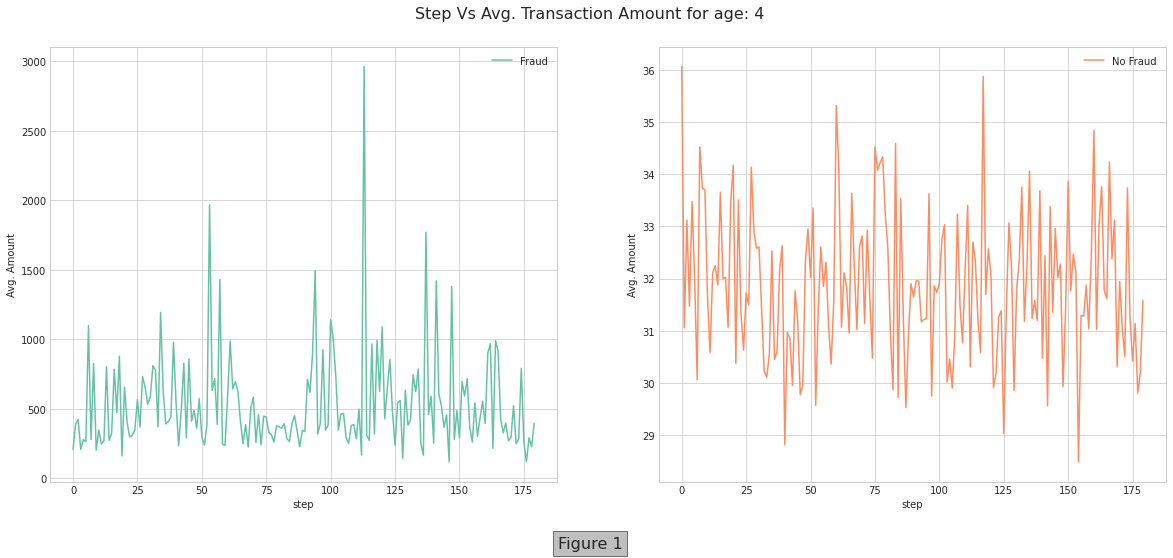

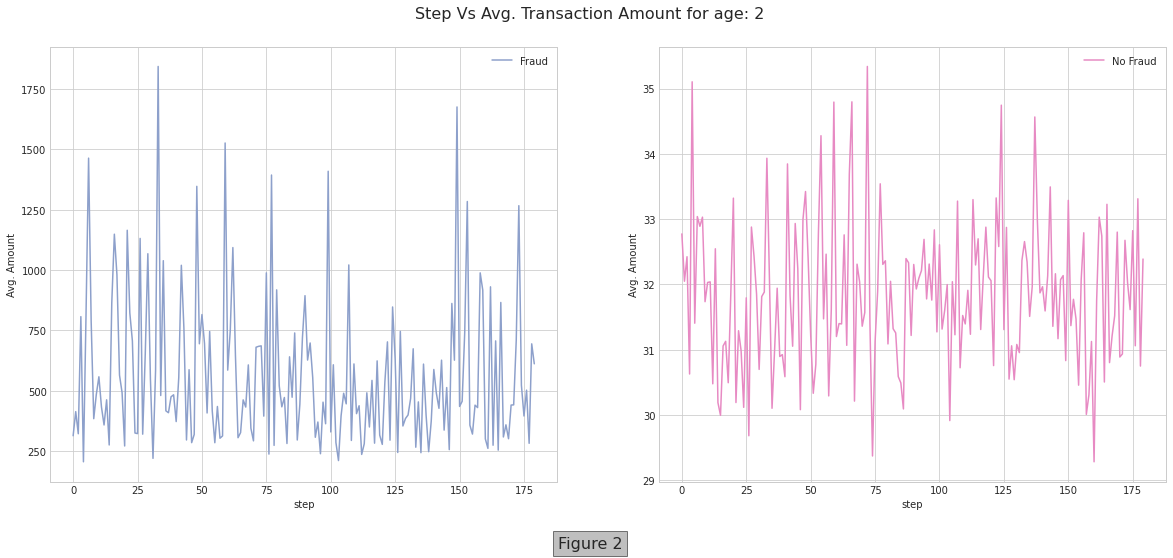

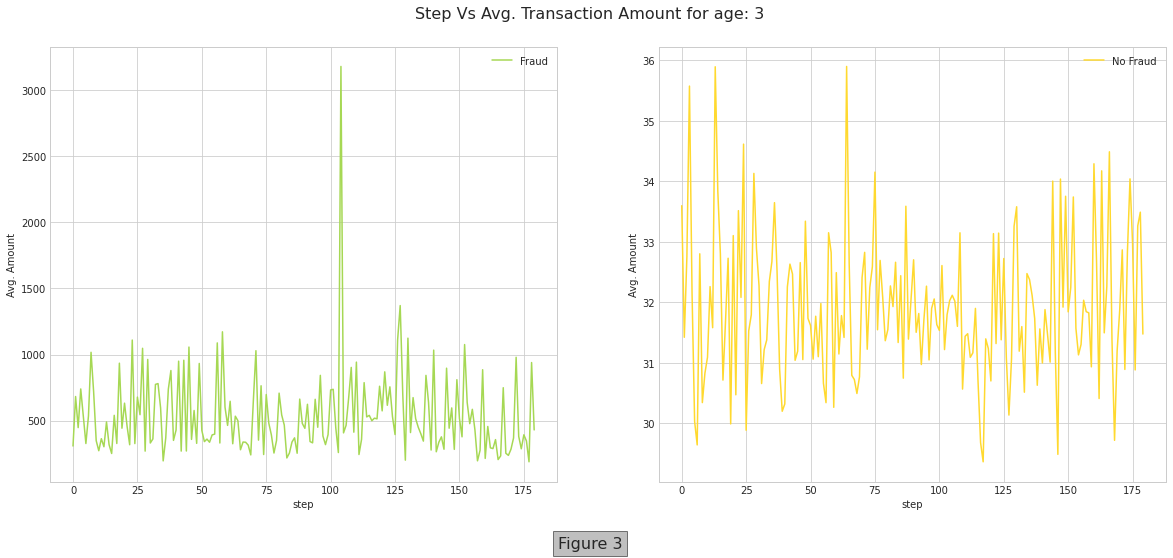

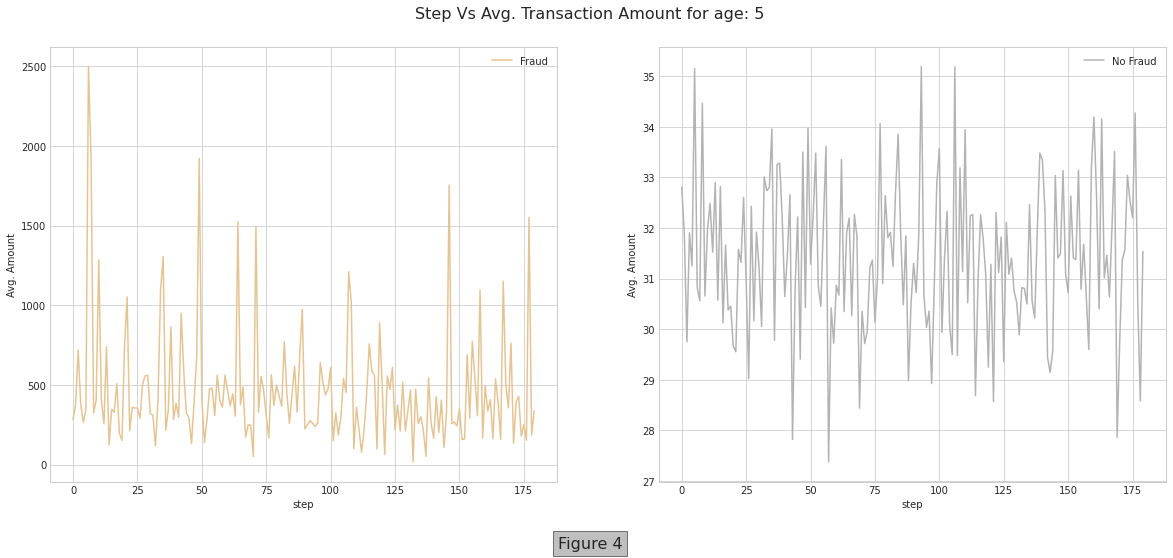

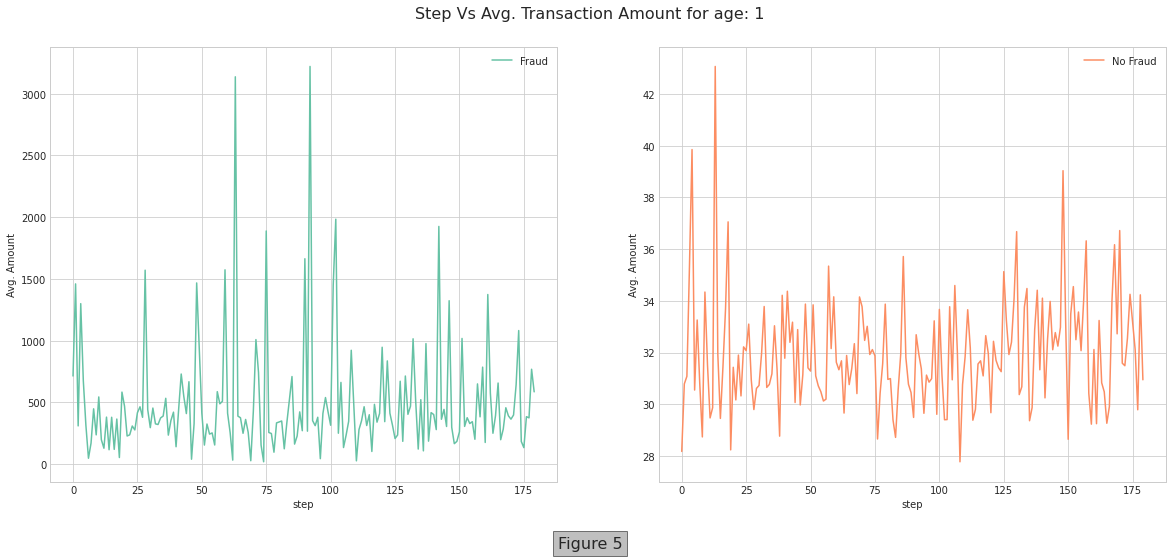

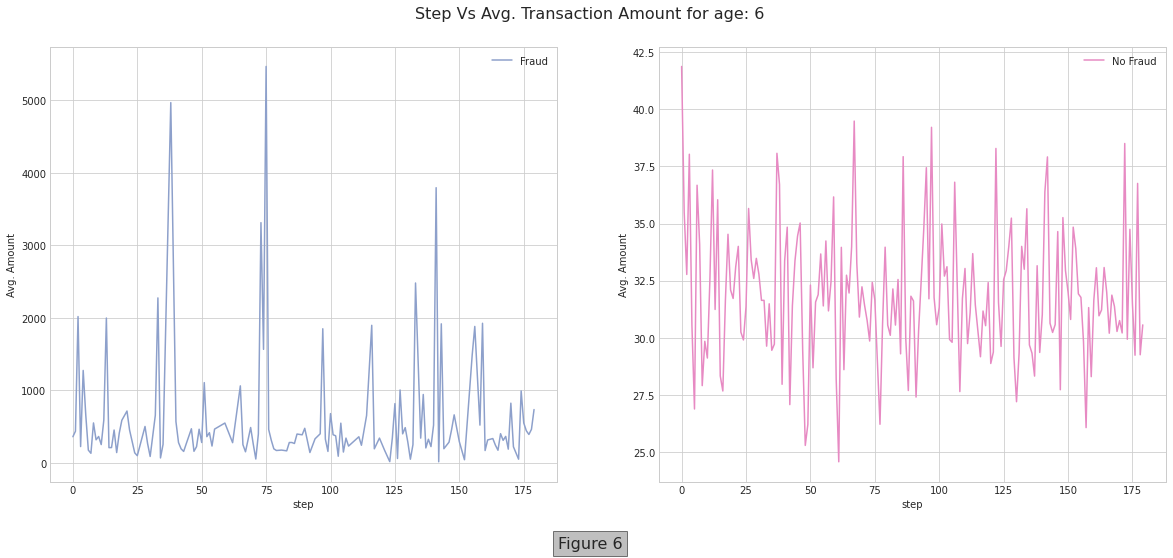

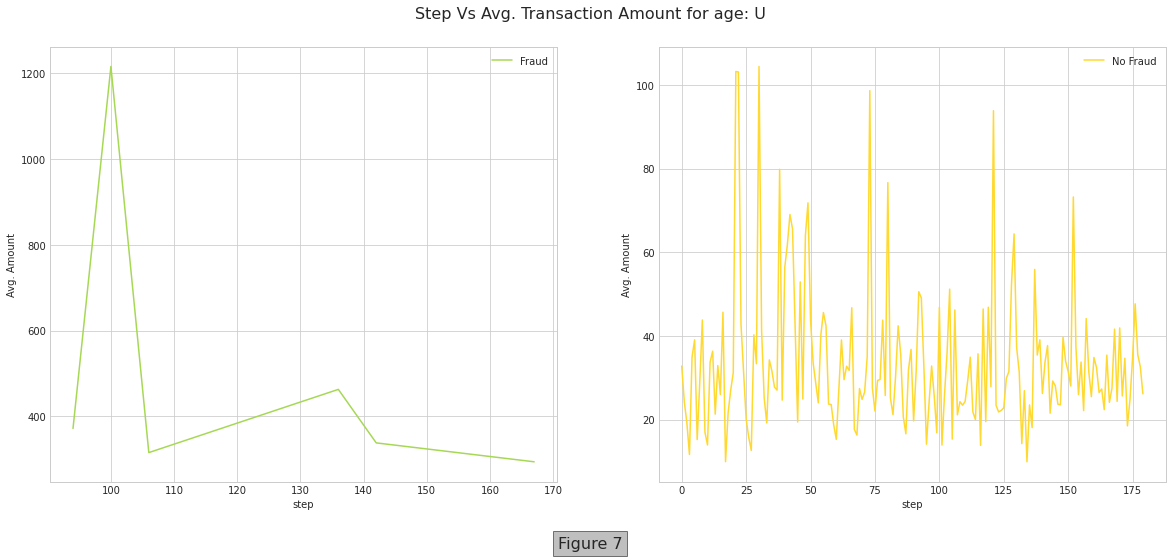

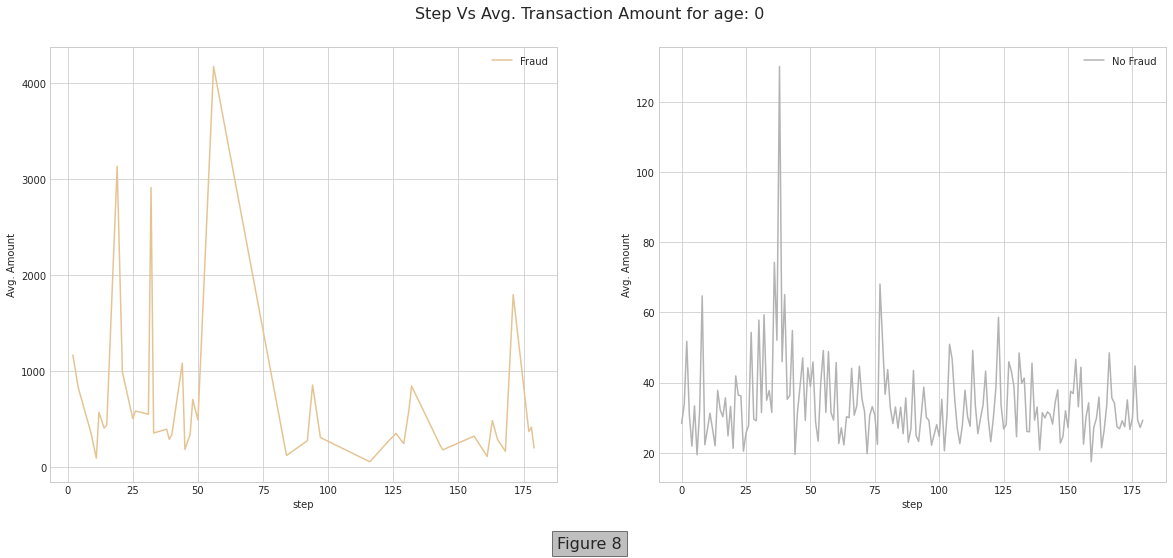

In [26]:
subplots_helper(bank_trans, 'age')

- From above plots its clear that across figures/features, the amount transacted is higher in Fraudulent cases
- The bank could take special interest in high value transactions and do a check before its approved (most banks do this now)

In [27]:
def cols_to_dict(col: str, kind: str = None):
    temp_dict = {}
    for val in fraud_df[col].unique():
        temp_dict[val] = len(nofraud_df[nofraud_df[col] == val])
    temp = pd.Series(temp_dict).to_frame(col)
    temp.iplot(kind = 'line' if kind else 'bar', 
              xTitle = col.title(), 
              yTitle = 'No. of Transactions', 
              title = f'No. of Normal Transactions done by {col.title()} in Fraudulent Transaction')
    return None

In [28]:
cols_to_dict('merchant')

In [29]:
cols_to_dict('customer', kind = 'line')

__Who are the Merchants where most number of fradulent transaction happens?__

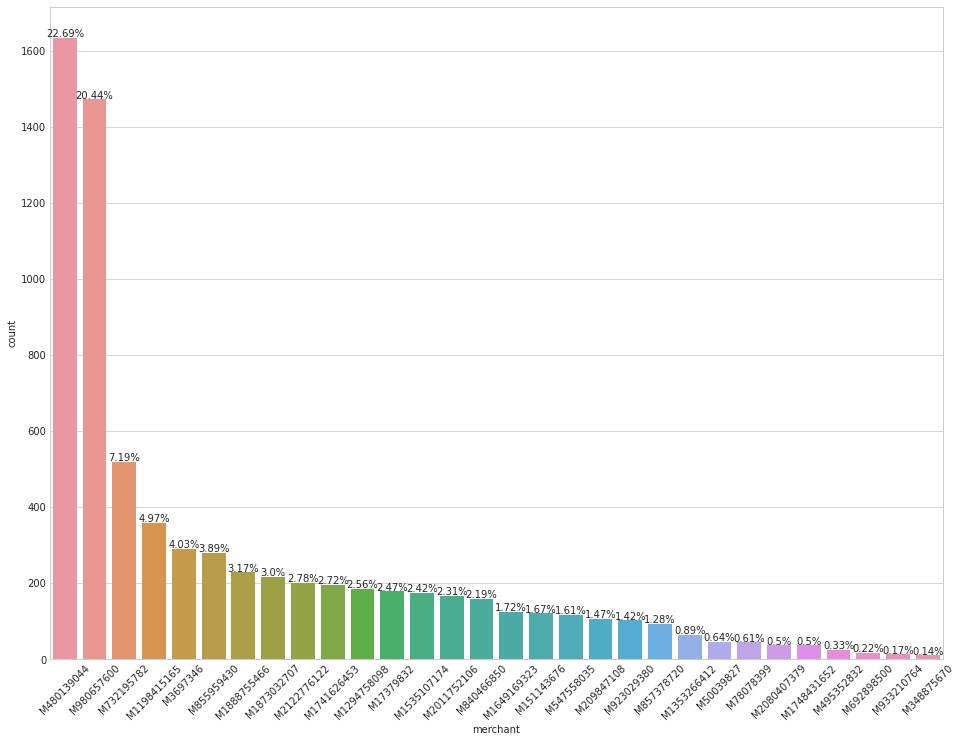

In [30]:
countplot_helper(fraud_df, col = 'merchant')

- __Of the total fradulent transaction, 43% happens with merchants M480139044 and M980657600__

- What category of items that customers buy with these merchants and how much amount transacted?

In [31]:
temp = fraud_df[fraud_df['merchant'] == 'M480139044'][['category', 'amount']]
print(f"Top Fraud category: {temp['category'].unique()}, Total amount transacted: {temp['amount'].sum()}")
temp = fraud_df[fraud_df['merchant'] == 'M980657600'][['category', 'amount']]
print(f"Top Fraud category: {temp['category'].unique()}, Total amount transacted: {temp['amount'].sum()}")

Top Fraud category: ['es_health'], Total amount transacted: 664804.3899999999
Top Fraud category: ['es_sportsandtoys'], Total amount transacted: 505311.62


- __Top fradulent transactions happen in es_health and es_sportandtoys category with total amount transacted 664,804 and 505,311 respectively.__
- What is the amount transacted in each category?

In [32]:
fraud_df.groupby('category')['amount'].sum().sort_values().iplot(kind = 'bar', 
                                                  xTitle = 'Category', 
                                                  yTitle = 'Amount', 
                                                  title = 'Total Fradulent Amount Transacted in each Category', 
                                                  color = 'green')

- es_travel is where most fraudulent transactions happen
- Which merchants were affected?

In [33]:
fraud_df[fraud_df['category'] == 'es_travel']['merchant'].unique()

array(['M495352832', 'M732195782', 'M2080407379'], dtype=object)

In [34]:
fraud_df[fraud_df['category'] == 'es_travel'][['merchant', 
                                               'amount']].groupby('merchant')['amount'].sum().iplot(kind = 'bar', 
                                                                                                               xTitle = 'Merchants', 
                                                                                                               yTitle = 'Amount', 
                                                                                                               title = 'Total Fraudulent Amount Transacted in es_travel Category by Merchants', 
                                                                                                               color = 'red')

In [35]:
def pivotplot_helper(df: pd.DataFrame, cat: str = None):
    if cat is None:
        print('Please enter the category to plot')
        return
    colors = ['brown', 'pink', 'red', 'blue', 'green', 'orange', 'purple']
    temp = df[df['category'] == cat][['merchant', 'amount', 'fraud']]
    temp = pd.pivot_table(data = temp, columns = ['merchant', 'fraud'], 
                          values = ['amount'], aggfunc = 'sum', fill_value = 0)

    temp.T.iplot(kind = 'bar', 
                xTitle = 'Merchant - Fraud', 
                yTitle = 'Amount', 
                title = f'Total Amount Transacted by Merchant-Fraud/noFraud for {cat} Category', 
                color = np.random.choice(colors, 1))
    return None

In [36]:
for cat in fraud_cats:
    pivotplot_helper(bank_trans, cat = cat)

- __From the above plots we can get which merchants are affected by fraudulent transaction by looking at the total amount transacted, may be the bank should flag these merchants and monitor transactions closely__
- __We can do the same analysis for customer feature but flagging customers would be a bad idea for PR__

# Data Pre-processing

#### Cardinality is high for the features 'customer' and 'merchant', we use Frequency Encoding for this

In [37]:
#Frequency Encoding customer and merchant features
for col in ['customer', 'merchant']:
    print(f"Frequency Encoding: {col} - {bank_trans[col].nunique()}")
    freq = bank_trans[col].value_counts()
    bank_trans[col] = bank_trans[col].apply(lambda x: freq[x])

Frequency Encoding: customer - 4112
Frequency Encoding: merchant - 50


In [38]:
#Label Encoding age, gender, category
for col in ['gender', 'age', 'category']:
    print(f"Label Encoding: {col} - {bank_trans[col].nunique()}")
    le = LabelEncoder()
    bank_trans[col] = le.fit_transform(bank_trans[col])

Label Encoding: gender - 4
Label Encoding: age - 8
Label Encoding: category - 15


In [39]:
bank_trans['amount'] = StandardScaler().fit_transform(np.array(bank_trans['amount']).reshape(-1, 1))

# Traning and Prediction

In [40]:
def plot_confusion(mat):
    plt.figure(figsize = (8, 4))
    sns.heatmap(pd.DataFrame(mat), annot = True, annot_kws = {"size": 25}, cmap = 'Blues', fmt = 'g')
    plt.title('Confusion matrix', y = 1.1, fontsize = 22)
    plt.ylabel('Actual', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.show()

In [41]:
sample = bank_trans.sample(frac = 1).reset_index(drop = True)
sample.shape

(594643, 8)

In [42]:
X = sample.drop(['fraud', 'step'], axis = 1)
y = sample['fraud'].copy()

In [43]:
#scale_pos_weight - sample Weights
num_pos_samples = y.value_counts().values[1]
num_neg_samples = y.value_counts().values[0]
num_neg_samples / num_pos_samples, np.sqrt(num_neg_samples / num_pos_samples)

(81.58930555555555, 9.0326798656631)

## When to use PR AUC?

#### When two classes are equally important

AUC would be the metric to use if the goal of the model is to perform equally well on both classes. Image classification between cats & dogs is a good example because the performance on cats is equally important on dogs.

#### When minority class is more important

PR AUC would be the metric to use if the focus of the model is to identify correctly as many positive samples as possible.

# Precision-Recall Curve

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced.

The precision-recall curve shows the tradeoff between precision and recall for different threshold. __A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.__ High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

A system with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels. A system with high precision but low recall is just the opposite, returning very few results, but most of its predicted labels are correct when compared to the training labels. An ideal system with high precision and high recall will return many results, with all results labeled correctly.

[Ref](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

In [44]:
def plot_pr_curve(precision, recall, avg_precision):
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = f"Avg. PR: {round(avg_precision, 2)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.55, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

In [45]:
from xgboost import XGBClassifier
import xgboost as xgb

xgb_params = {
         'objective': 'binary:logistic',
         'lambda': 0.0030282073258141168, 
         'alpha': 0.01563845128469084,
         'colsample_bytree': 0.55,
         'subsample': 0.7,
         'learning_rate': 0.01,
         'max_depth': 9,
         'random_state': 2020, 
         'min_child_weight': 257,
         'eval_metric': 'aucpr',
         'seed': 2021,
         'scale_pos_weight': np.sqrt(num_neg_samples / num_pos_samples) #np.sqrt()?
         }

Fold: 1
[0]	train-aucpr:0.69050	valid-aucpr:0.69199
[200]	train-aucpr:0.87655	valid-aucpr:0.87600
[400]	train-aucpr:0.89343	valid-aucpr:0.89139
[600]	train-aucpr:0.90062	valid-aucpr:0.89716
[800]	train-aucpr:0.90440	valid-aucpr:0.89970
[1000]	train-aucpr:0.90761	valid-aucpr:0.90207
[1200]	train-aucpr:0.91051	valid-aucpr:0.90432
[1400]	train-aucpr:0.91292	valid-aucpr:0.90619
[1600]	train-aucpr:0.91498	valid-aucpr:0.90760
[1800]	train-aucpr:0.91642	valid-aucpr:0.90871
[2000]	train-aucpr:0.91784	valid-aucpr:0.90975
[2200]	train-aucpr:0.91915	valid-aucpr:0.91061
[2400]	train-aucpr:0.92028	valid-aucpr:0.91135
[2600]	train-aucpr:0.92122	valid-aucpr:0.91190
[2800]	train-aucpr:0.92214	valid-aucpr:0.91243
[3000]	train-aucpr:0.92299	valid-aucpr:0.91296
[3200]	train-aucpr:0.92376	valid-aucpr:0.91329
[3400]	train-aucpr:0.92443	valid-aucpr:0.91361
[3600]	train-aucpr:0.92510	valid-aucpr:0.91397
[3800]	train-aucpr:0.92568	valid-aucpr:0.91420
[4000]	train-aucpr:0.92625	valid-aucpr:0.91450
[4200]	train

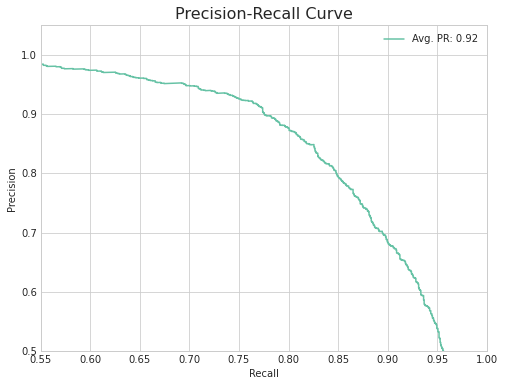

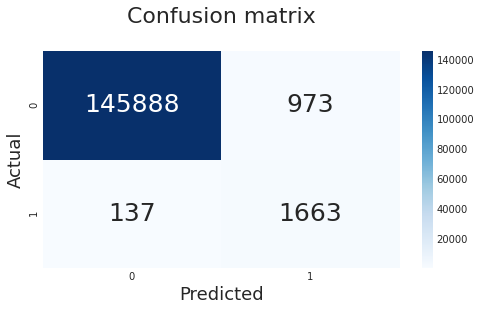

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    146861
           1       0.63      0.92      0.75      1800

    accuracy                           0.99    148661
   macro avg       0.81      0.96      0.87    148661
weighted avg       0.99      0.99      0.99    148661


Fold: 2
[0]	train-aucpr:0.68505	valid-aucpr:0.70210
[200]	train-aucpr:0.87432	valid-aucpr:0.87627
[400]	train-aucpr:0.89128	valid-aucpr:0.89239
[600]	train-aucpr:0.89818	valid-aucpr:0.89909
[800]	train-aucpr:0.90184	valid-aucpr:0.90262
[1000]	train-aucpr:0.90520	valid-aucpr:0.90545
[1200]	train-aucpr:0.90806	valid-aucpr:0.90775
[1400]	train-aucpr:0.91044	valid-aucpr:0.90960
[1600]	train-aucpr:0.91258	valid-aucpr:0.91108
[1800]	train-aucpr:0.91438	valid-aucpr:0.91219
[2000]	train-aucpr:0.91578	valid-aucpr:0.91316
[2200]	train-aucpr:0.91712	valid-aucpr:0.91399
[2400]	train-aucpr:0.91823	valid-aucpr:0.91472
[2600]	train-aucpr:0.91914	valid-auc

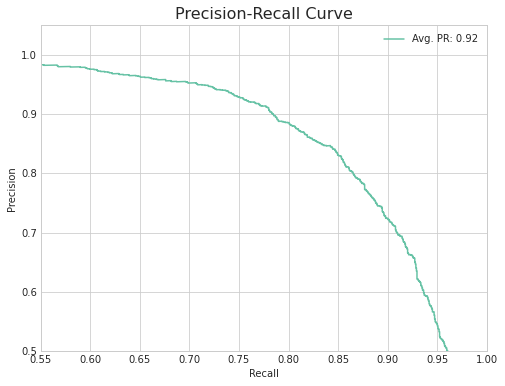

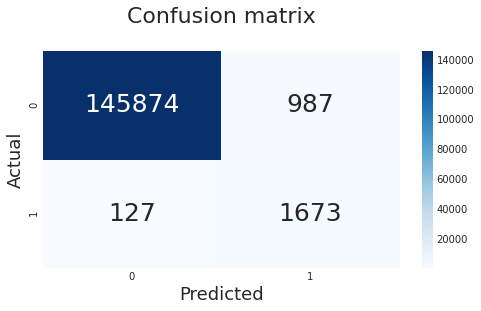

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    146861
           1       0.63      0.93      0.75      1800

    accuracy                           0.99    148661
   macro avg       0.81      0.96      0.87    148661
weighted avg       0.99      0.99      0.99    148661


Fold: 3
[0]	train-aucpr:0.69327	valid-aucpr:0.68283
[200]	train-aucpr:0.87588	valid-aucpr:0.87373
[400]	train-aucpr:0.89298	valid-aucpr:0.89062
[600]	train-aucpr:0.89997	valid-aucpr:0.89655
[800]	train-aucpr:0.90343	valid-aucpr:0.89859
[1000]	train-aucpr:0.90665	valid-aucpr:0.90109
[1200]	train-aucpr:0.90946	valid-aucpr:0.90352
[1400]	train-aucpr:0.91169	valid-aucpr:0.90535
[1600]	train-aucpr:0.91356	valid-aucpr:0.90685
[1800]	train-aucpr:0.91521	valid-aucpr:0.90824
[2000]	train-aucpr:0.91647	valid-aucpr:0.90918
[2200]	train-aucpr:0.91769	valid-aucpr:0.91004
[2400]	train-aucpr:0.91885	valid-aucpr:0.91085
[2600]	train-aucpr:0.91982	valid-auc

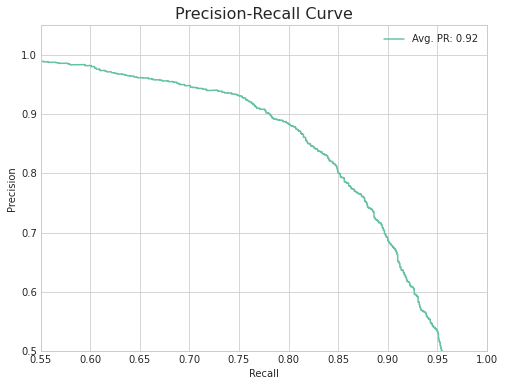

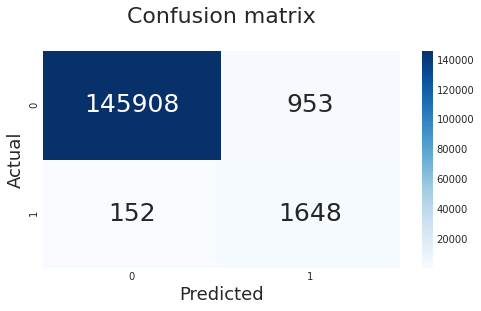

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    146861
           1       0.63      0.92      0.75      1800

    accuracy                           0.99    148661
   macro avg       0.82      0.95      0.87    148661
weighted avg       0.99      0.99      0.99    148661


Fold: 4
[0]	train-aucpr:0.69275	valid-aucpr:0.68149
[200]	train-aucpr:0.87886	valid-aucpr:0.86408
[400]	train-aucpr:0.89565	valid-aucpr:0.88184
[600]	train-aucpr:0.90120	valid-aucpr:0.88780
[800]	train-aucpr:0.90508	valid-aucpr:0.89146
[1000]	train-aucpr:0.90851	valid-aucpr:0.89440
[1200]	train-aucpr:0.91131	valid-aucpr:0.89677
[1400]	train-aucpr:0.91343	valid-aucpr:0.89842
[1600]	train-aucpr:0.91534	valid-aucpr:0.89978
[1800]	train-aucpr:0.91691	valid-aucpr:0.90082
[2000]	train-aucpr:0.91814	valid-aucpr:0.90156
[2200]	train-aucpr:0.91937	valid-aucpr:0.90244
[2400]	train-aucpr:0.92049	valid-aucpr:0.90323
[2600]	train-aucpr:0.92147	valid-auc

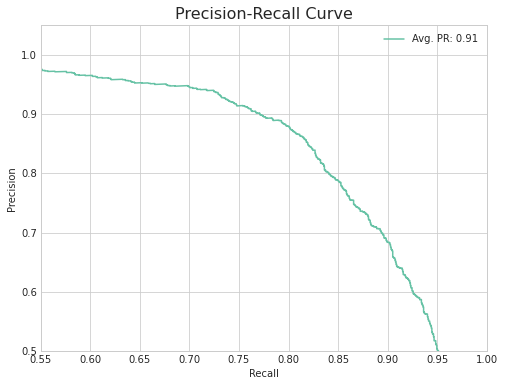

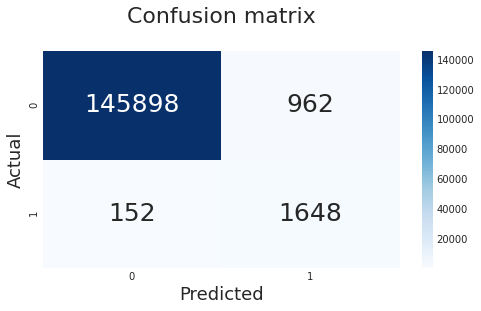

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    146860
           1       0.63      0.92      0.75      1800

    accuracy                           0.99    148660
   macro avg       0.82      0.95      0.87    148660
weighted avg       0.99      0.99      0.99    148660




In [46]:
n_folds = 4
preds_xg = []

skf = StratifiedKFold(n_splits = n_folds)

for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    
    xg_train = xgb.DMatrix(Xtrain, label = ytrain)
    xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

    clf = xgb.train(xgb_params,
                              xg_train,
                              10000,
                              verbose_eval = 200,
                              evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                              early_stopping_rounds = 100)

    valid_preds = clf.predict(xg_valid)
    
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    
    precision, recall, _ = precision_recall_curve(yvalid, valid_preds)
    plot_pr_curve(precision, recall, avg_precision)
    
    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)
    plot_confusion(conf_mat)
    
    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")
    
    preds_xg.append(valid_preds)
    print()

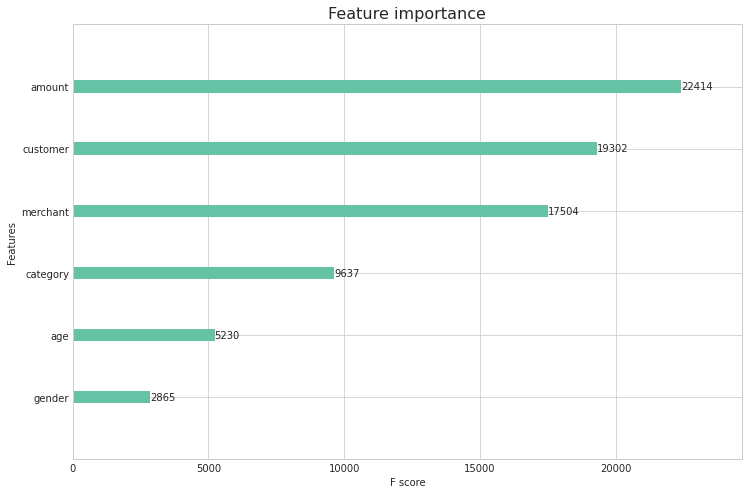

In [47]:
xgb.plot_importance(clf);

- __Our Xgboost model does a good job by keeping the False Negatives low (high Recall) which is preferred in Fraud/Spam/Churn detection setup__
- __When using *'scale_pos_weight' = sqrt(neg/pos)*, the precision has increased (lesser FP) but the recall has decresed a bit (higher FN) compared to using *'scale_pos_weight' = neg/pos*__
- From the feature importance plot, merchant and amount are the most important ones, which confirms what we observed from the plots in the EDA part
    <font color = 'green'>
    
    - Flagging the merchants where high fraudulent transactions happens
    - Checking whenever high amount in transacted
    
    </font>

- We will attempt undersampling below, to check whether we can improve our model performance

# UnderSampling Majority Class

- The original dataset has positive/negative sampels in the ratio 1:80
-  We will undersample the majority so that we get a ratio of 1:30

In [48]:
temp_fraud = bank_trans[bank_trans['fraud'] == 1].reset_index(drop = True)
temp_nofraud = bank_trans[bank_trans['fraud'] == 0].reset_index(drop = True)
temp_nofraud = temp_nofraud.sample(n = 216000).reset_index(drop = True)
df = pd.concat([temp_fraud, temp_nofraud]).reset_index(drop = True)
df.shape

(223200, 8)

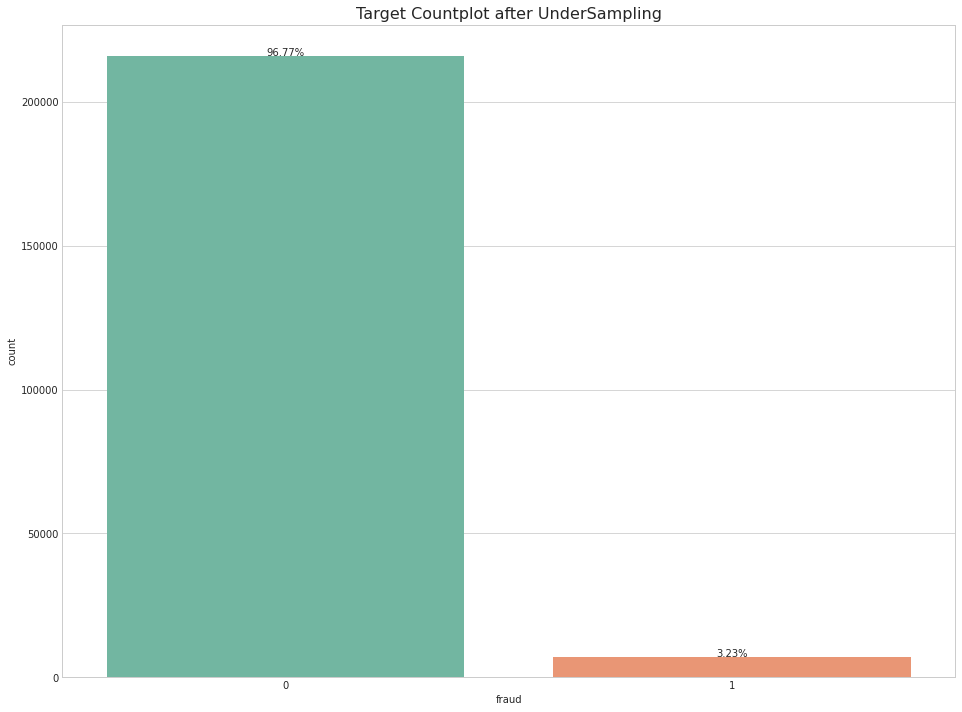

In [49]:
countplot_helper(df, 'fraud', title = 'Target Countplot after UnderSampling')

In [50]:
X = df.drop(['fraud', 'step'], axis = 1)
y = df['fraud'].copy()

In [51]:
#scale_pos_weight - sample Weights
num_pos_samples = y.value_counts().values[1]
num_neg_samples = y.value_counts().values[0]
xgb_params['scale_pos_weight'] = np.sqrt(num_neg_samples / num_pos_samples) #set the new class weights

num_neg_samples / num_pos_samples, np.sqrt(num_neg_samples / num_pos_samples)

(30.0, 5.477225575051661)

Fold: 1
[0]	train-aucpr:0.79865	valid-aucpr:0.77387
[200]	train-aucpr:0.92783	valid-aucpr:0.91493
[400]	train-aucpr:0.93471	valid-aucpr:0.92308
[600]	train-aucpr:0.93811	valid-aucpr:0.92756
[800]	train-aucpr:0.93996	valid-aucpr:0.92990
[1000]	train-aucpr:0.94211	valid-aucpr:0.93234
[1200]	train-aucpr:0.94360	valid-aucpr:0.93413
[1400]	train-aucpr:0.94484	valid-aucpr:0.93560
[1600]	train-aucpr:0.94588	valid-aucpr:0.93692
[1800]	train-aucpr:0.94663	valid-aucpr:0.93761
[2000]	train-aucpr:0.94750	valid-aucpr:0.93862
[2200]	train-aucpr:0.94820	valid-aucpr:0.93936
[2400]	train-aucpr:0.94883	valid-aucpr:0.93996
[2600]	train-aucpr:0.94940	valid-aucpr:0.94061
[2800]	train-aucpr:0.94998	valid-aucpr:0.94121
[3000]	train-aucpr:0.95047	valid-aucpr:0.94158
[3200]	train-aucpr:0.95096	valid-aucpr:0.94199
[3400]	train-aucpr:0.95135	valid-aucpr:0.94238
[3600]	train-aucpr:0.95175	valid-aucpr:0.94274
[3800]	train-aucpr:0.95212	valid-aucpr:0.94307
[4000]	train-aucpr:0.95245	valid-aucpr:0.94333
[4200]	train

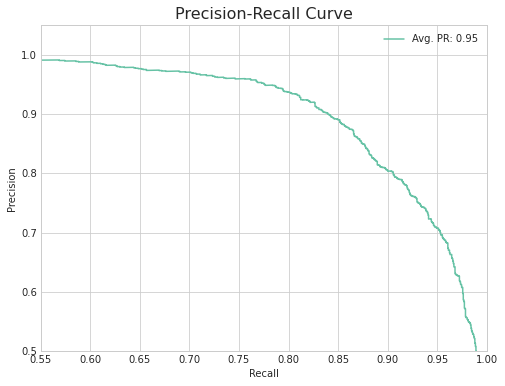

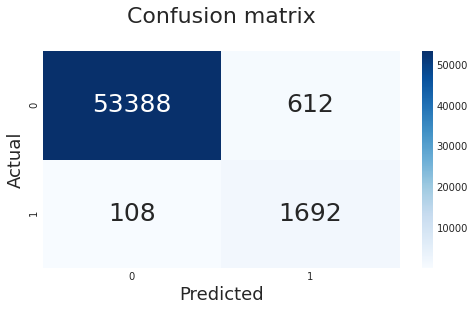

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     54000
           1       0.73      0.94      0.82      1800

    accuracy                           0.99     55800
   macro avg       0.87      0.96      0.91     55800
weighted avg       0.99      0.99      0.99     55800


Fold: 2
[0]	train-aucpr:0.78622	valid-aucpr:0.81263
[200]	train-aucpr:0.92501	valid-aucpr:0.93395
[400]	train-aucpr:0.93260	valid-aucpr:0.93994
[600]	train-aucpr:0.93602	valid-aucpr:0.94221
[800]	train-aucpr:0.93805	valid-aucpr:0.94415
[1000]	train-aucpr:0.94054	valid-aucpr:0.94627
[1200]	train-aucpr:0.94216	valid-aucpr:0.94736
[1400]	train-aucpr:0.94354	valid-aucpr:0.94839
[1600]	train-aucpr:0.94477	valid-aucpr:0.94936
[1800]	train-aucpr:0.94571	valid-aucpr:0.95001
[2000]	train-aucpr:0.94655	valid-aucpr:0.95068
[2200]	train-aucpr:0.94728	valid-aucpr:0.95109
[2400]	train-aucpr:0.94798	valid-aucpr:0.95146
[2600]	train-aucpr:0.94851	valid-auc

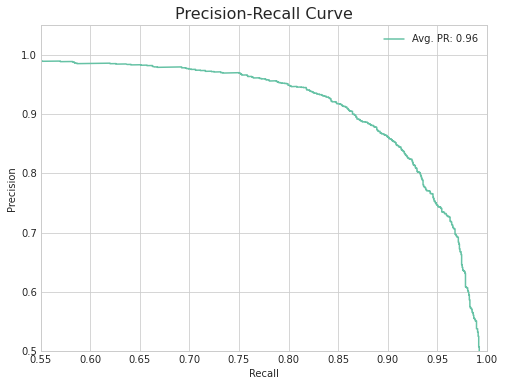

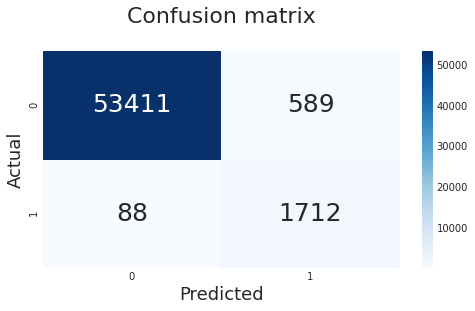

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     54000
           1       0.74      0.95      0.83      1800

    accuracy                           0.99     55800
   macro avg       0.87      0.97      0.91     55800
weighted avg       0.99      0.99      0.99     55800


Fold: 3
[0]	train-aucpr:0.79419	valid-aucpr:0.79178
[200]	train-aucpr:0.92938	valid-aucpr:0.92312
[400]	train-aucpr:0.93649	valid-aucpr:0.93086
[600]	train-aucpr:0.93973	valid-aucpr:0.93396
[800]	train-aucpr:0.94170	valid-aucpr:0.93573
[1000]	train-aucpr:0.94390	valid-aucpr:0.93758
[1200]	train-aucpr:0.94551	valid-aucpr:0.93881
[1400]	train-aucpr:0.94697	valid-aucpr:0.93991
[1600]	train-aucpr:0.94811	valid-aucpr:0.94076
[1800]	train-aucpr:0.94901	valid-aucpr:0.94133
[2000]	train-aucpr:0.94990	valid-aucpr:0.94202
[2200]	train-aucpr:0.95062	valid-aucpr:0.94247
[2400]	train-aucpr:0.95125	valid-aucpr:0.94291
[2600]	train-aucpr:0.95178	valid-auc

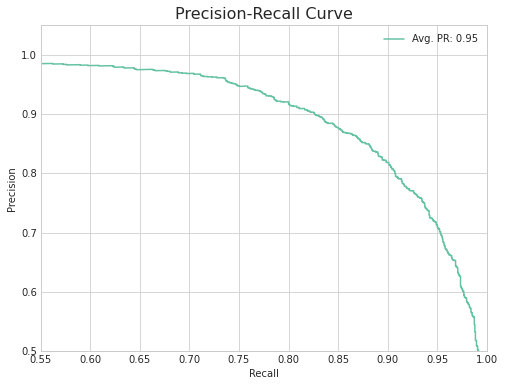

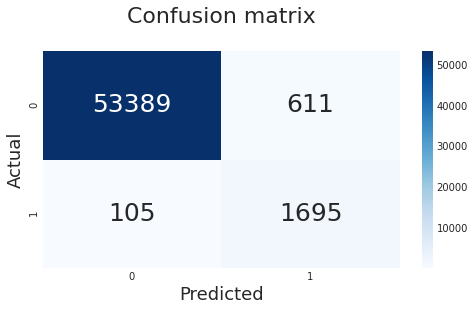

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     54000
           1       0.74      0.94      0.83      1800

    accuracy                           0.99     55800
   macro avg       0.87      0.97      0.91     55800
weighted avg       0.99      0.99      0.99     55800


Fold: 4
[0]	train-aucpr:0.79589	valid-aucpr:0.78457
[200]	train-aucpr:0.93011	valid-aucpr:0.92149
[400]	train-aucpr:0.93714	valid-aucpr:0.92800
[600]	train-aucpr:0.94044	valid-aucpr:0.93073
[800]	train-aucpr:0.94226	valid-aucpr:0.93195
[1000]	train-aucpr:0.94449	valid-aucpr:0.93411
[1200]	train-aucpr:0.94608	valid-aucpr:0.93570
[1400]	train-aucpr:0.94735	valid-aucpr:0.93692
[1600]	train-aucpr:0.94838	valid-aucpr:0.93794
[1800]	train-aucpr:0.94920	valid-aucpr:0.93859
[2000]	train-aucpr:0.95013	valid-aucpr:0.93934
[2200]	train-aucpr:0.95081	valid-aucpr:0.94007
[2400]	train-aucpr:0.95146	valid-aucpr:0.94061
[2600]	train-aucpr:0.95200	valid-auc

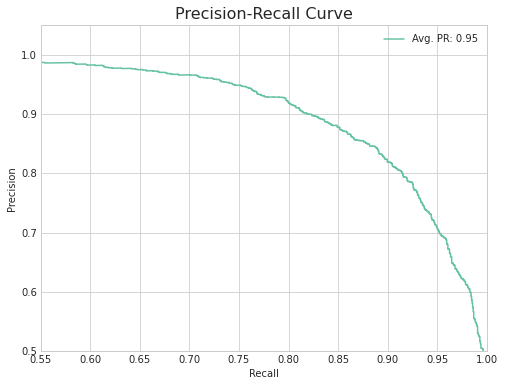

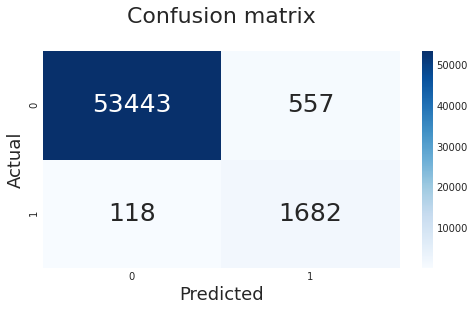

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     54000
           1       0.75      0.93      0.83      1800

    accuracy                           0.99     55800
   macro avg       0.87      0.96      0.91     55800
weighted avg       0.99      0.99      0.99     55800




In [52]:
n_folds = 4
preds_xg = []

skf = StratifiedKFold(n_splits = n_folds)

for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    
    xg_train = xgb.DMatrix(Xtrain, label = ytrain)
    xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

    clf = xgb.train(xgb_params,
                              xg_train,
                              10000,
                              verbose_eval = 200,
                              evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                              early_stopping_rounds = 100)

    valid_preds = clf.predict(xg_valid)
    
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    
    precision, recall, _ = precision_recall_curve(yvalid, valid_preds)
    plot_pr_curve(precision, recall, avg_precision)
    
    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)
    plot_confusion(conf_mat)
    
    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")
    
    preds_xg.append(valid_preds)
    print()

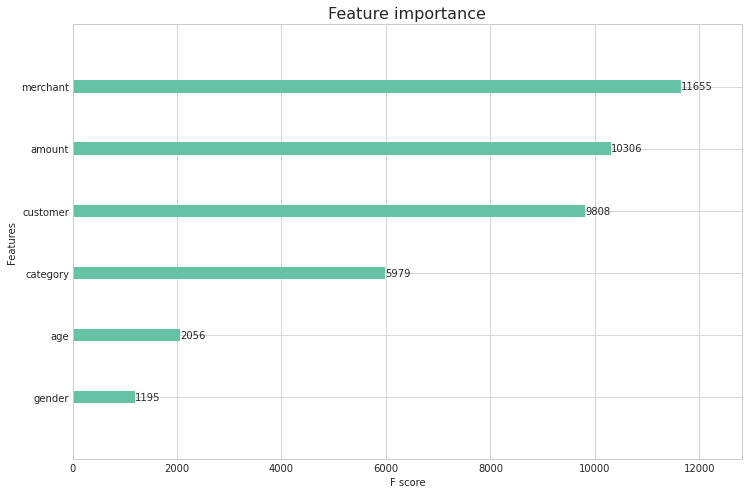

In [53]:
xgb.plot_importance(clf);

- __Recall has improved well after undersampling and also the Precision__
- __Average Precision-Recall Score has also improved well__
- We can further improve the performance by doing feature engineering (create more features)
- Also, if only high Recall is desired, we can do so by setting the model parameter *scale_pos_weight* to just neg/pos instead of sqrt(neg/pos)

In [54]:
finish = time()
print(strftime("%H:%M:%S", gmtime(finish - start)))

01:49:21
